📊 Code Completion Benchmark Analysis

This notebook analyzes the end-to-end performance of our code completion plugin based on the data collected in `benchmark_results.csv`.
 

In [1]:
# 1. Setup and Data Loading
#  First, we import the necessary libraries and load our benchmark data into a pandas DataFrame.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set plotting style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [3]:
# Load the data
try:
    df = pd.read_csv('benchmark_results.csv')
    print("✅ Data loaded successfully!")
    print(f"Total records found: {len(df)}")
except FileNotFoundError:
    print("❌ Error: benchmark_results.csv not found. Make sure it's in the same directory as this notebook.")
    df = pd.DataFrame() # Create an empty df to avoid further errors

if not df.empty:
    # Display the first few rows to understand the structure
    display(df.head())

✅ Data loaded successfully!
Total records found: 1600


,timestamp,model_ids,prefix,suffix,e2e_time_ms,error,response_message,meta_query_id,completion_model_id,completion_model_name,completion_text,generation_time_ms,confidence
0,2025-09-22T13:56:39.060324,[1],import java.util.*;\nimport java.lang.reflect....,return primes.get(primes.size() - 1);\...,84.0428,NaN,Completions generated successfully. Ready for ...,6c9846fd-58a5-48f2-b0e3-f93c40e555c6,1,deepseek-ai/deepseek-coder-1.3b-base,\n }\n,61,1.0
1,2025-09-22T13:56:39.226354,[1],import java.util.*;\nimport java.lang.reflect....,}\n},165.7808,NaN,Completions generated successfully. Ready for ...,a3d0511a-e555-4563-acf1-1c062607adfc,1,deepseek-ai/deepseek-coder-1.3b-base,\n return new String(arr);\n,116,1.0
2,2025-09-22T13:56:39.314124,[1],import java.util.*;\nimport java.lang.reflect....,return boredoms;\n }\n},87.1278,NaN,Completions generated successfully. Ready for ...,50c4e0e5-1f5f-4446-a7b1-154c362686db,1,deepseek-ai/deepseek-coder-1.3b-base,\n }\n,61,1.0
3,2025-09-22T13:56:39.399312,[1],"def is_multiply_prime(a: int) -> bool:\n """"...",\n,85.4436,NaN,Completions generated successfully. Ready for ...,cf823418-b1c8-46f1-9c06-1bcf29fe6856,1,deepseek-ai/deepseek-coder-1.3b-base,\n return False,61,1.0
4,2025-09-22T13:56:39.535994,[1],import java.util.*;\nimport java.lang.reflect....,"if (str.startsWith(""-"")) {\n ...",136.1985,NaN,Completions generated successfully. Ready for ...,d9229a9e-9def-4715-bac6-24019eab32ef,1,deepseek-ai/deepseek-coder-1.3b-base,\n int sum = 0;\n,111,1.0


In [6]:
# ## 2. Data Cleaning and Feature Engineering
# To perform a deep analysis, we need to clean the data and create new features from the existing columns. We will:
# 1. Filter out any failed requests.
# 2. Calculate the lengths of the prefix, suffix, and the generated completion.
# 3. Estimate the number of tokens to calculate generation speed.

if not df.empty:
    # Filter out failed requests (where an error is not null)
    initial_rows = len(df)
    df_success = df[df['error'].isnull()].copy()
    print(f"Filtered out {initial_rows - len(df_success)} failed requests. Analyzing {len(df_success)} successful requests.")

    # --- Feature Engineering ---
    # Calculate prompt and completion lengths
    df_success['prefix_length'] = df_success['prefix'].str.len()
    df_success['suffix_length'] = df_success['suffix'].str.len()
    df_success['total_prompt_length'] = df_success['prefix_length'] + df_success['suffix_length']
    df_success['completion_length'] = df_success['completion_text'].str.len()

    # Estimate the number of tokens generated (a simple heuristic is word count)
    # A more advanced method would use a real tokenizer.
    df_success['num_completion_tokens'] = df_success['completion_text'].str.split().str.len()

    # --- Calculate Performance Metrics ---
    # Avoid division by zero for empty completions or zero-time generations
    # Calculate Time per Token (ms/token)
    df_success['e2e_time_per_token'] = df_success['e2e_time_ms'] / df_success['num_completion_tokens']
    df_success['generation_time_per_token'] = df_success['generation_time_ms'] / df_success['num_completion_tokens']

    # Calculate Tokens per Second (throughput)
    # (tokens / ms) * 1000 = tokens/sec
    df_success['tokens_per_second'] = (df_success['num_completion_tokens'] / df_success['generation_time_ms']) * 1000

    # Replace infinite values that may result from division by zero with NaN, then drop them
    df_success.replace([np.inf, -np.inf], np.nan, inplace=True)
    rows_before_dropna = len(df_success) # Add this line
    df_success.dropna(subset=['e2e_time_per_token', 'tokens_per_second'], inplace=True)
    rows_after_dropna = len(df_success) # Add this line
    
    dropped_for_analysis = rows_before_dropna - rows_after_dropna
    if dropped_for_analysis > 0:
        print(f"\\n⚠️ Dropped {dropped_for_analysis} rows with empty completions before analysis.")

    
    print("\n✅ Feature engineering complete. New columns added:")
    display(df_success[['e2e_time_ms', 'generation_time_ms', 'total_prompt_length', 'completion_length', 'num_completion_tokens', 'tokens_per_second']].head())


Filtered out 0 failed requests. Analyzing 1600 successful requests.
\n⚠️ Dropped 135 rows with empty completions before analysis.

✅ Feature engineering complete. New columns added:


,e2e_time_ms,generation_time_ms,total_prompt_length,completion_length,num_completion_tokens,tokens_per_second
0,84.0428,61,753.0,11.0,1.0,16.393443
1,165.7808,116,1113.0,33.0,3.0,25.862069
2,87.1278,61,905.0,11.0,1.0,16.393443
3,85.4436,61,571.0,21.0,2.0,32.786885
4,136.1985,111,1457.0,26.0,4.0,36.036036


Note that the token estimation is based on word count and not entirely reliable

--- 🔬 End-to-End (E2E) Latency ---
Mean:   186.31 ms
Median (P50): 138.86 ms
P90:    334.00 ms (90% of requests were faster than this)
P95:    517.07 ms
P99:    703.92 ms
Mean:   4.52 tokens


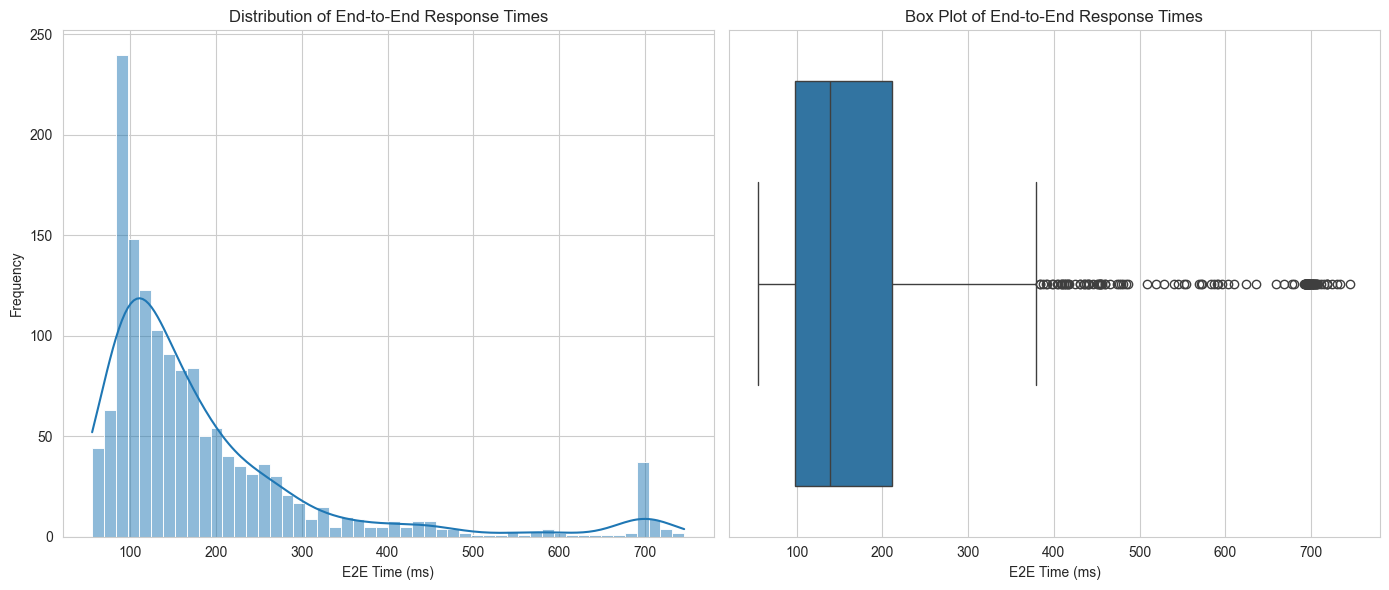

In [14]:
# ## 3. Overall Performance Summary 📜
# Here are the key statistics for the end-to-end (E2E) latency and server-side generation time.

if not df_success.empty:
    # Calculate key statistics for E2E time
    e2e_stats = df_success['e2e_time_ms'].describe(percentiles=[.5, .90, .95, .99])
    
    print("--- 🔬 End-to-End (E2E) Latency ---")
    print(f"Mean:   {e2e_stats['mean']:.2f} ms")
    print(f"Median (P50): {e2e_stats['50%']:.2f} ms")
    print(f"P90:    {e2e_stats['90%']:.2f} ms (90% of requests were faster than this)")
    print(f"P95:    {e2e_stats['95%']:.2f} ms")
    print(f"P99:    {e2e_stats['99%']:.2f} ms")

    token_stats = df_success['num_completion_tokens'].describe(percentiles=[.5, .90, .95, .99])
    print(f"Token Mean:   {token_stats['mean']:.2f} tokens")
    
    
    # --- Visualization: Latency Distribution ---
    plt.figure(figsize=(14, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_success['e2e_time_ms'], kde=True, bins=50)
    plt.title('Distribution of End-to-End Response Times')
    plt.xlabel('E2E Time (ms)')
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_success['e2e_time_ms'])
    plt.title('Box Plot of End-to-End Response Times')
    plt.xlabel('E2E Time (ms)')
    
    plt.tight_layout()
    plt.show()

--- ⚡ Model Generation Throughput ---
Mean:   25.27 tokens/sec
Median: 23.81 tokens/sec


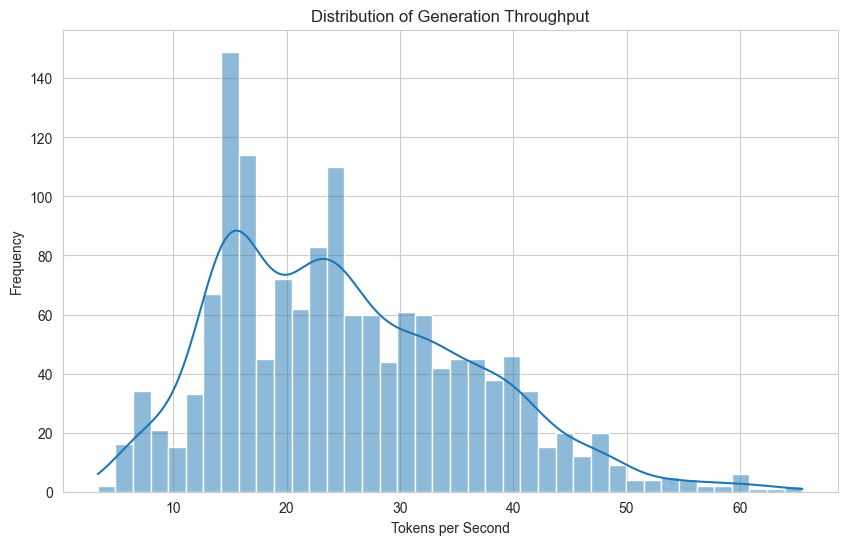

In [15]:
# ## 4. Throughput Analysis (Tokens per Second) 🚀
# Throughput measures how fast the model generates text, independent of network latency.

if not df_success.empty:
    throughput_stats = df_success['tokens_per_second'].describe(percentiles=[.5, .90, .95])

    print("--- ⚡ Model Generation Throughput ---")
    print(f"Mean:   {throughput_stats['mean']:.2f} tokens/sec")
    print(f"Median: {throughput_stats['50%']:.2f} tokens/sec")
    
    # --- Visualization: Throughput Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df_success['tokens_per_second'], kde=True, bins=40)
    plt.title('Distribution of Generation Throughput')
    plt.xlabel('Tokens per Second')
    plt.ylabel('Frequency')
    plt.show()

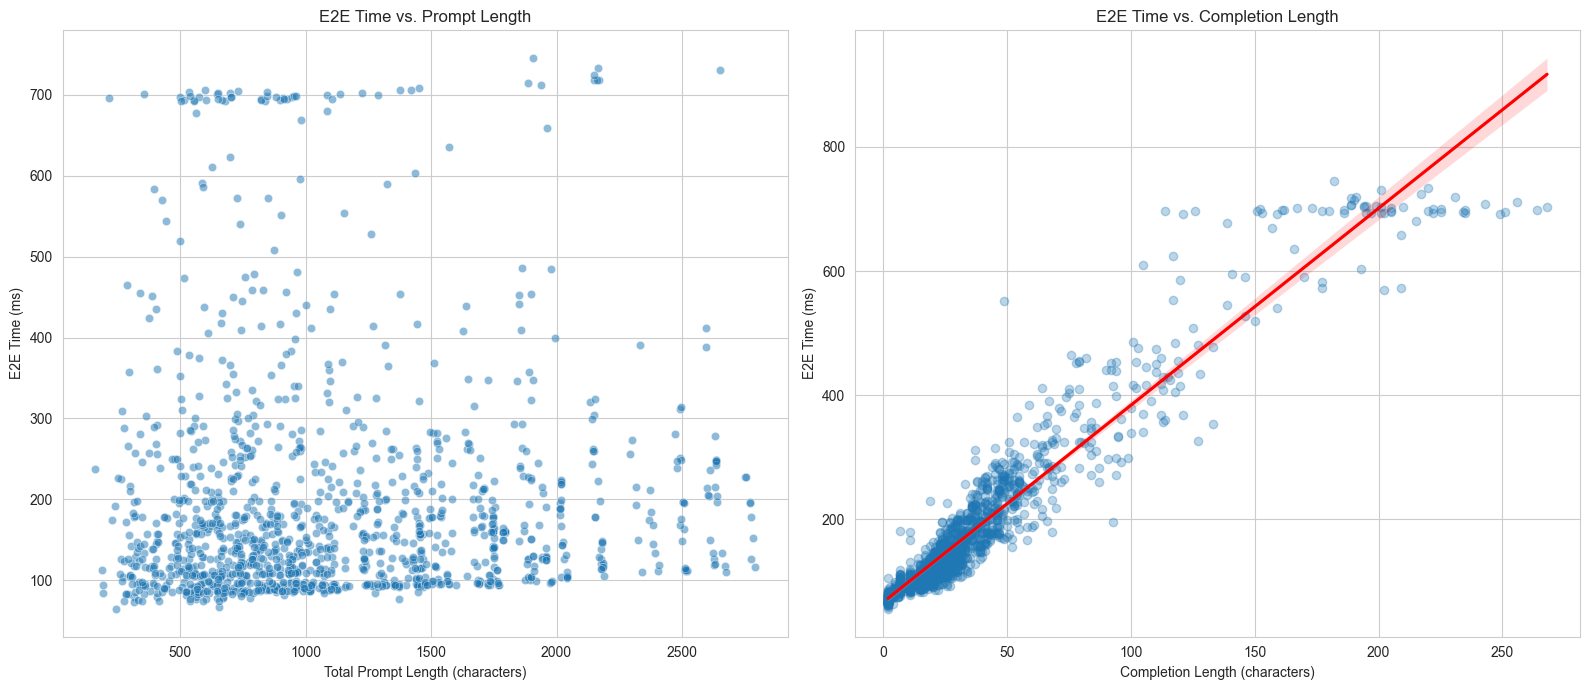

Key Observations:
1. The plot on the left shows the relationship between prompt size and latency.
2. The plot on the right shows a clearer correlation: as the **length of the generated code increases**, the end-to-end time tends to increase as well. The red line shows the trend.


In [16]:
# ## 5. Performance vs. Input/Output Length 📏
# Let's investigate how the length of the prompt and the generated completion affects the response time.

if not df_success.empty:
    plt.figure(figsize=(16, 7))
    
    # E2E Time vs. Total Prompt Length
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_success, x='total_prompt_length', y='e2e_time_ms', alpha=0.5)
    plt.title('E2E Time vs. Prompt Length')
    plt.xlabel('Total Prompt Length (characters)')
    plt.ylabel('E2E Time (ms)')

    # E2E Time vs. Completion Length
    plt.subplot(1, 2, 2)
    sns.regplot(data=df_success, x='completion_length', y='e2e_time_ms', 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('E2E Time vs. Completion Length')
    plt.xlabel('Completion Length (characters)')
    plt.ylabel('E2E Time (ms)')
    
    plt.tight_layout()
    plt.show()

    # --- Analysis ---
    print("Key Observations:")
    print("1. The plot on the left shows the relationship between prompt size and latency.")
    print("2. The plot on the right shows a clearer correlation: as the **length of the generated code increases**, the end-to-end time tends to increase as well. The red line shows the trend.")


In [17]:
# ## 6. Identifying the Slowest Requests 🐢
# To find potential bottlenecks, let's look at the top 10 slowest requests. This can help identify specific types of code that are slow to process.

if not df_success.empty:
    slowest_requests = df_success.sort_values(by='e2e_time_ms', ascending=False).head(10)

    print("--- Top 10 Slowest Requests ---")
    display(slowest_requests[['prefix', 'completion_text', 'e2e_time_ms', 'completion_length', 'total_prompt_length', 'num_completion_tokens']])


--- Top 10 Slowest Requests ---


,prefix,completion_text,e2e_time_ms,completion_length,total_prompt_length,num_completion_tokens
745,"//Given two arrays operator, and operand. The ...",\n case '+':\n operand[count] = op...,745.6996,182.0,1908.0,19.0
1143,from typing import Union\n\ndef compare_one(a:...,\n if a > b:\n return a\n ...,733.5912,220.0,2165.0,28.0
1565,import java.util.*;\nimport java.lang.reflect....,\n return letterGrades;\n }\n \n ...,730.5486,201.0,2652.0,18.0
1561,from typing import Union\n\ndef compare_one(a:...,"\n elif isinstance(a, str) and isinstance(b...",724.2623,217.0,2149.0,26.0
158,from typing import Union\n\ndef compare_one(a:...,\n elif float(a_tmp) < b:\n ...,718.6578,191.0,2170.0,18.0
1066,import java.util.*;\nimport java.lang.reflect....,"\n int j = binarySearch(last, sorte...",718.6552,231.0,2162.0,19.0
1036,from typing import Union\n\ndef compare_one(a:...,"\n #elif isinstance(a, list) and isinstance...",718.0077,189.0,2149.0,27.0
411,"//Given two arrays operator, and operand. The ...","\n operand.splice(count + 1, 1);\n ...",714.6982,190.0,1886.0,19.0
121,import java.util.*;\nimport java.lang.reflect....,\n if (diff == strength) {\n ...,711.8624,256.0,1940.0,16.0
1401,import java.util.*;\nimport java.lang.reflect....,\n while ((min <= max) || (!result.isEm...,708.4992,243.0,1452.0,21.0
